In [4]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

def plot_lung_segment(image, mask, ax=None):
    if not ax: fig, ax = plt.subplots(figsize=(12, 10))
    ax.imshow(image)
    ax.imshow(mask, alpha=0.4)
    ax.set_axis_off()

# Train Lung Segmentation

In [25]:
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50
from sklearn.metrics import roc_auc_score
from transform import lung_segmentation_transfrom
from model_data import ModelData
import pretrainedmodels
from datetime import datetime
from metrics import dice, iou
import pandas as pd
from layers import SaveFeature
from unet import Unet
from dataset import LungSegmentationDataset
from recorder import TrainingRecoder

In [213]:
PATH = Path('/home/dattran/data/xray-thesis/LungSegmentation')
IMAGE_DN = 'images'
MASK_DN = 'masks'

models_name = datetime.strftime(datetime.now(), '%Y%m%d-%H%M%S')
print(models_name)
model_path = PATH/'models'/models_name
model_path.mkdir(parents=True, exist_ok=True)

20190211-124944


In [38]:
import torchvision.transforms as transforms
from constant import IMAGENET_MEAN, IMAGENET_STD

class Denormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    
    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

denorm = transforms.Compose([
    Denormalize(IMAGENET_MEAN, IMAGENET_STD),
    transforms.ToPILImage()
])

to_pil = transforms.ToPILImage()

In [34]:
from torch.utils.data import DataLoader
def get_md(sz, bs):
    train = pd.read_csv(PATH/'train.csv', header=None).iloc[:, 1].values
    val = pd.read_csv(PATH/'val.csv', header=None).iloc[:, 1].values
    tfms = lung_segmentation_transfrom(sz)
    datasets = ImageData.get_ds(LungSegmentationDataset, (train, train), (val, val), tfms, path=PATH, size=sz)
    md = ModelData(PATH, datasets, bs, num_workers=6, classes=None)
    return md

def get_test(sz, bs, what='mont'):
    if what == 'mont':
        test = pd.read_csv(PATH/'test_mont.csv', header=None).iloc[:, 1].values
    elif what == 'jsrt':
        test = pd.read_csv(PATH/'test_jsrt.csv', header=None).iloc[:, 1].values
    
    _, tfm = lung_segmentation_transfrom(sz)
    dataset = LungSegmentationDataset(test, test, tfm, PATH, sz)
    return DataLoader(dataset, bs, num_workers=6)

md = get_md(256, 32)

In [35]:
def test(what='mont'):
    dl = get_test(256, 16, what)
    preds = []
    targs = []
    for x, y in iter(dl):
        x, y = VV(x), VV(y)
        pred = learn.model(x)

        targs.append(y.cpu())
        preds.append(pred.cpu())

    targs = torch.cat(targs)
    preds = torch.cat(preds)
    
    print(what, dice_s(preds, targs), iou_s(preds, targs))
    del targs, preds

## Unet

In [8]:
def dice_s(preds, targets):
    return dice(torch.sigmoid(preds), targets)

def iou_s(preds, targets):
    return iou(torch.sigmoid(preds), targets)

In [15]:
class UnetModel():
    def __init__(self, model, name='unet'):
        self.model, self.name = model, name
        
    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.backbone), [6]))
        return lgs + [children(self.model)[1:]]

In [16]:
unet = to_gpu(Unet())
unet_model = UnetModel(unet)

In [20]:
learn = ConvLearner(md, unet_model, models_name=model_path)
learn.opt_fn=optim.Adam
learn.crit = nn.BCEWithLogitsLoss()
learn.metrics = [dice_s, iou_s]

In [21]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 256, 256]),
                           ('output_shape', [-1, 64, 128, 128]),
                           ('trainable', False),
                           ('nb_params', tensor(9408))])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 128, 128]),
                           ('output_shape', [-1, 64, 128, 128]),
                           ('trainable', False),
                           ('nb_params', tensor(128))])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 128, 128]),
                           ('output_shape', [-1, 64, 128, 128]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 128, 128]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape

In [28]:
# learn.lr_find()

epoch      trn_loss   val_loss   dice_s     iou_s          
    0      0.675995   7.370566652205614e+24 0.447621   0.275332  



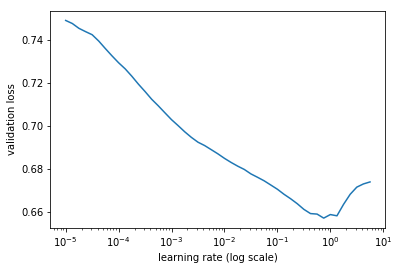

In [29]:
# learn.sched.plot(0, 0)

In [27]:
lr=1e-2
wd=1e-7
lrs = np.array([lr/100,lr/10,lr])

In [28]:
loss_recorder = TrainingRecoder(model_path)
md = get_md(256, 32)
layer_opt = learn.get_layer_opt(lrs, wd)
loss_recorder.new_phase(layer_opt)
learn.sched = None
learn.fit_gen(learn.model, md, layer_opt, 10, metrics=[dice_s, iou_s], \
              cycle_len=2, use_clr=(20,10), best_save_name='best', \
              callbacks=[loss_recorder])

epoch      trn_loss   val_loss   dice_s     iou_s          
    0      0.61413    0.574525   0.902315   0.808511  
    1      0.599255   0.562369   0.9148     0.83524        
    2      0.594841   0.554277   0.913866   0.837046       
    3      0.588188   0.552231   0.926312   0.852709       
    4      0.586819   0.540745   0.927979   0.854158       
    5      0.58419    0.548926   0.934736   0.871572       
    6      0.582763   0.548316   0.927557   0.858928       
    7      0.582076   0.540911   0.938747   0.876022       
    8      0.581314   0.551693   0.931829   0.870578       
    9      0.579961   0.544542   0.941631   0.88625        
    10     0.580325   0.543382   0.941676   0.878569       
    11     0.578834   0.539757   0.94272    0.885508       
    12     0.579923   0.535381   0.939347   0.880598       
    13     0.577375   0.541022   0.946892   0.891524       
    14     0.577083   0.540434   0.940506   0.884895       
    15     0.575418   0.53813    0.948365   0

[0.536320884656636, array(0.94868, dtype=float32), array(0.89689)]

In [29]:
loss_recorder.save()

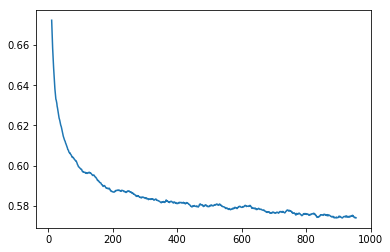

In [30]:
learn.sched.plot_loss()

In [36]:
test('mont')
test('jsrt')

mont tensor(0.9708) 0.9299691253089767
jsrt tensor(0.9688) 0.9185864315427635


In [261]:
from skimage import morphology, color

def plot_lung_segment(image, mask, gt_mask=None, ax=None, boundary=False):
    if not ax: fig, ax = plt.subplots(figsize=(12, 10))
    image = blend_segmentation(image, mask, gt_mask, boundary, alpha=1)
    ax.imshow(image)
#     ax.imshow(image)
#     if boundary: mask = morphology.dilation(mask, morphology.disk(3)) - mask
#     ax.imshow(mask, alpha=0.4, vmin=0, vmax=1, cmap='Reds')
#     if gt_mask is not None:
#         boundary = morphology.dilation(gt_mask, morphology.disk(3)) - gt_mask
#         ax.imshow(boundary, alpha=0.4, vmin=0, vmax=1, cmap='Greens')
    ax.set_axis_off()

def blend_segmentation(image, mask, gt_mask=None, boundary=False, alpha=1):
    h, w = image.size
    color_mask = np.zeros((h, w, 3)) # PIL Image
    if boundary: mask = morphology.dilation(mask, morphology.disk(3)) - mask
    color_mask[mask==1] = [1, 0, 0] # RGB
    
    if gt_mask is not None:
        gt_boundary = morphology.dilation(gt_mask, morphology.disk(3)) - gt_mask
        color_mask[gt_boundary==1] = [0, 1, 0] # RGB
    
    image_hsv = color.rgb2hsv(image)
    color_mask_hsv = color.rgb2hsv(color_mask)
    
    image_hsv[..., 0] = color_mask_hsv[..., 0]
    image_hsv[..., 1] = color_mask_hsv[..., 1] * alpha
    
    return color.hsv2rgb(image_hsv)
    
    

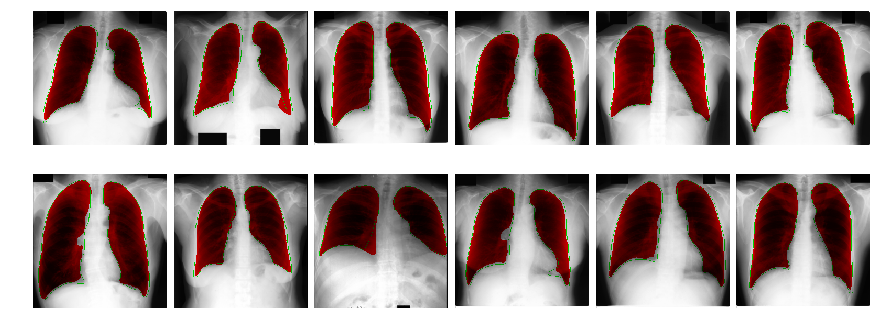

In [262]:
def plot_val():
    x, y = md.val_ds[10]
    print(x.shape)
    py = torch.sigmoid(learn.model(V(x[None])))
    print(py)
    py = (py[0].cpu()>0.5).type(torch.FloatTensor) # py: ByteTensor (uint8) -> FloatTensor (float32)
    plot_lung_segment(denorm(x), to_pil(py))

def plot_test(what):
    dl = get_test(256, 16, what)
    images, gt_masks = next(iter(dl))
    fig, axes = plt.subplots(2, 6, figsize=(15, 6))
    for i, ax in enumerate(axes.flat):
        image, gt_mask = images[i], gt_masks[i] 
        
        py = torch.sigmoid(learn.model(V(image)[None]))
        py = (py[0].cpu() > 0.5).type(torch.FloatTensor) # 1, 256, 256
        labels = skimage.measure.label(py[0].numpy()) # 256, 256
        mask = np.logical_or(labels==2, labels==1).astype(np.float32) # left nd right lung

        plot_lung_segment(denorm(image), mask, gt_mask.numpy()[0], boundary=False, ax=ax)
        plt.subplots_adjust(wspace=0.05, hspace=0.001)
plot_test('jsrt')

## Test on ChestX-ray 14 dataset

In [40]:
from scipy import ndimage
from matplotlib.patches import Rectangle

In [41]:
PATH = Path('/home/dattran/data/xray-thesis/chestX-ray14')
IMAGE_DN = 'images'
CSV_FILE = 'train.csv'
df = pd.read_csv(PATH/CSV_FILE, header=None, sep=' ')
image_names = df.iloc[:, 0].values

In [52]:
unet = Unet(True, model_name=models_name).cuda()

In [47]:
sample_image_names = np.random.choice(image_names, 16)

In [58]:
_, (tfm, _) = lung_segmentation_transfrom(256)

In [169]:
import matplotlib.cm as cm

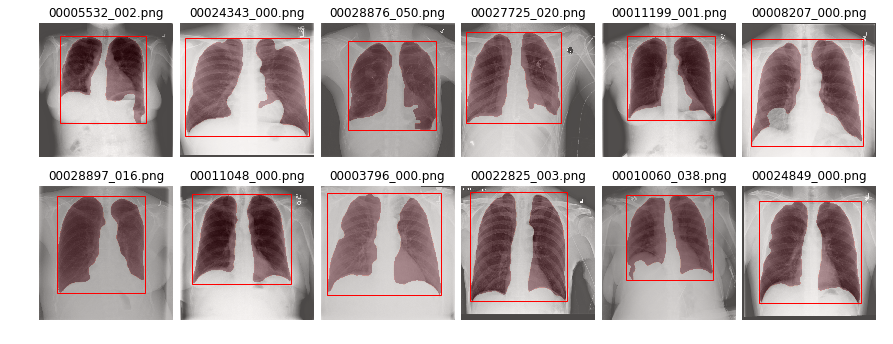

In [211]:
fig, axes = plt.subplots(2, 6, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    image = Image.open(PATH/IMAGE_DN/sample_image_names[i]).convert('RGB')    
    ax.set_title(sample_image_names[i])

    image_v = V(tfm(image)[None])
    py = torch.sigmoid(unet(image_v))
    py = (py[0].cpu() > 0.5).type(torch.FloatTensor) # 1, 256, 256
    labels = skimage.measure.label(py[0].numpy()) # 256, 256
    mask = np.logical_or(labels==2, labels==1).astype(np.float32) # left nd right lung, 0 for background
    mask = cv2.resize(mask, (1024, 1024))
    
    plot_lung_segment(image, mask, ax=ax)

    slice_y, slice_x = ndimage.find_objects(mask, 1)[0]
    xy = (slice_x.start, slice_y.start)
    height = slice_y.stop - slice_y.start
    width= slice_x.stop - slice_x.start
    rect = Rectangle(xy, width, height, linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    plt.subplots_adjust(wspace=0.05, hspace=0.001)
    

In [210]:
# roi_image = image[slice_y.start:slice_y.stop, slice_x.start: slice_x.stop]
# show_img(roi_image)
